In [1]:
from sklearn.decomposition import PCA
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import torch

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
#         print(input)
        activation[name] = input[0].detach()
    return hook

In [3]:
model = models.resnet18().to("cuda")
weights = torch.load("./pca_feature_extractor.torch")
model.load_state_dict(weights["model_state_dict"])
model.fc.register_forward_hook(getActivation('fc'))

to_tens = transforms.ToTensor()

In [4]:
lc_df = pd.read_csv("./zonal_stats/all_modis.csv")
lc_df.head()

,school_id,LC_Type1,LC_Type1_name,latitude,longitude
0,105970,12,Croplands,14.933336,120.500000
1,105768,13,Urban and built-up,15.640054,120.890625
2,108556,9,Savannas,14.861095,121.000000
3,136571,13,Urban and built-up,14.645669,121.062500
4,105190,12,Croplands,15.498674,120.833799


In [5]:
mex_feats, phl_feats, tan_feats = [], [], []
im_names = ['Savannas', 'Grasslands', 'Urban and built-up', 'Croplands', 'Forests', 'Waterbodies & Wetlands']
class_dict = {im_names[i]:0 for i in range(len(im_names))}


for country in os.listdir("../dimagery/"):
    
    print(country)
    
    for school in os.listdir("../dimagery/" + country):
        
        try:
        
            school_id = school.split("_")[1].split(".")[0]
            im = to_tens(np.array(Image.open("../dimagery/" + country + "/" + school).convert("RGB"))).unsqueeze(0).to("cuda")
            lc = lc_df[lc_df["school_id"] == school_id].drop_duplicates(subset = "school_id")["LC_Type1_name"].squeeze()

            feats = model(im)

            if class_dict[lc] != 0:
                class_dict[lc].append(activation["fc"][0].detach().cpu().numpy())
            else:
                class_dict[lc] = [activation["fc"][0].detach().cpu().numpy()]
                
        except Exception as e:
            
            print(e)        

mex
unhashable type: 'Series'
unhashable type: 'Series'
tan


/opt/conda/envs/caoe/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


phl
unhashable type: 'Series'


In [6]:
for key, values in class_dict.items():
    if (values != 0):
        if len(values) > 1:
            pca = PCA(n_components = 2)
            pca.fit(np.array(values))
            key = key.replace(" ", "_").replace("-", "_").lower()
            print(key)
            pd.DataFrame(pca.transform(np.array(values))).to_csv(f"./pca_feats/{key}.csv", index = False)    

savannas
grasslands
urban_and_built_up
croplands
forests
waterbodies_&_wetlands


In [7]:
import matplotlib.pyplot as plt

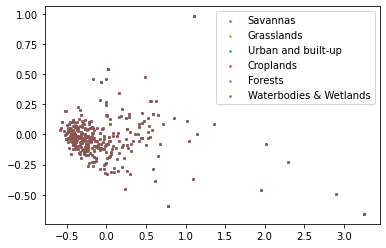

In [8]:
for lc_type in class_dict.keys():
    key = key.replace(" ", "_").replace("-", "_").lower()
    cur_df = pd.read_csv(f"./pca_feats/{key}.csv")
    plt.scatter(x = cur_df["0"], y = cur_df["1"], s = 2)

plt.legend(list(class_dict.keys()))
# plt.savefig("./figures/country_feats_scatterplot.png")

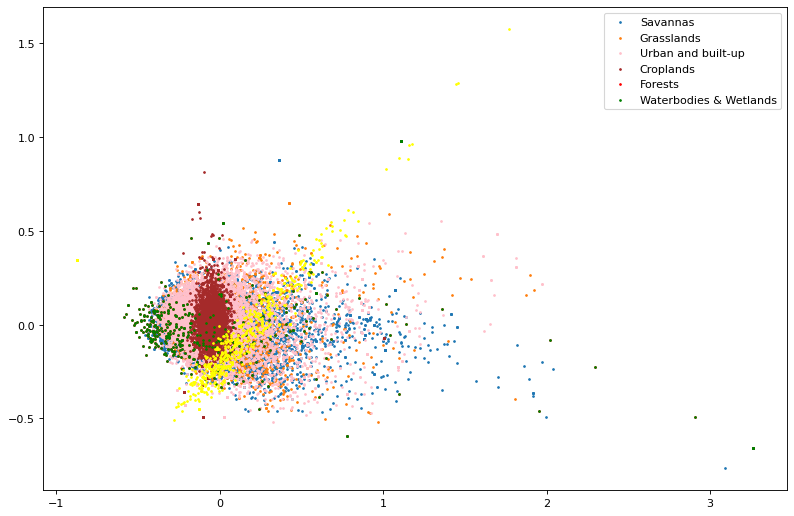

In [57]:
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)

cur_df = pd.read_csv(f"./pca_feats/savannas.csv")
plt.scatter(x = cur_df["0"], y = cur_df["1"], s = 2)

cur_df = pd.read_csv(f"./pca_feats/croplands.csv")
plt.scatter(x = cur_df["0"], y = cur_df["1"], s = 2)

cur_df = pd.read_csv(f"./pca_feats/grasslands.csv")
plt.scatter(x = cur_df["0"], y = cur_df["1"], s = 2, c = "pink")

cur_df = pd.read_csv(f"./pca_feats/urban_and_built_up.csv")
plt.scatter(x = cur_df["0"], y = cur_df["1"], s = 2, c = "brown")

cur_df = pd.read_csv(f"./pca_feats/waterbodies_&_wetlands.csv")
plt.scatter(x = cur_df["0"], y = cur_df["1"], s = 2, c = "red")

cur_df = pd.read_csv(f"./pca_feats/waterbodies_&_wetlands.csv")
plt.scatter(x = cur_df["0"], y = cur_df["1"], s = 2, c = "green")

cur_df = pd.read_csv(f"./pca_feats/forests.csv")
plt.scatter(x = cur_df["0"], y = cur_df["1"], s = 2, c = "yellow")
plt.legend(list(class_dict.keys()))
plt.savefig("./figures/lc_feats_scatterplot.png")

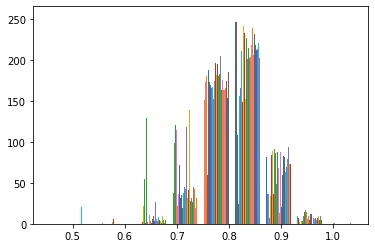

In [49]:
plt.hist(values)
plt.savefig("./figures/collection_images_dist_example.png")

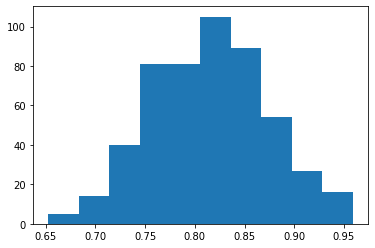

In [48]:
plt.hist(values[0])
plt.savefig("./figures/one_image_dist_example.png")